In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(s=list(np.arange(0, 20, 2)),
                                 g=list(np.arange(0, 20, 2)),
                                 N=[500, 1000, 2000])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [71]:
#Network size
N = 1000
#Random connectivity
g = 3.5
J = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

#Structure
s = 2.8
sigma_diag = 1.6
sigma_off = 0.8
sigma_mn = np.array([[sigma_diag, -sigma_off],
                     [sigma_off, sigma_diag]])
sigma_mm = np.eye(2)
n_var = 4
sigma_nn = n_var * np.eye(2)

covariance_top = np.hstack([sigma_mm, sigma_mn])
covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
covariance = np.vstack([covariance_top, covariance_bot])

loadings = np.random.multivariate_normal(np.zeros(4), covariance, size=N)

m1 = loadings[:,0]
m2 = loadings[:,1]
n1 = loadings[:,2]
n2 = loadings[:,3]
M = np.multiply.outer(m1, n1) + np.multiply.outer(m2, n2)

#Combine into one connectivity
W = J + s*M / N

#Recompute orthogonal m1 and m2
U, S, VT = np.linalg.svd(M)
m1 = U[:,0]
m2 = U[:,1]

In [72]:
rnn = Time_Cts_RNN(W, tanh, g=1)
ode_method = Euler(0.05)
sim = Simulation(rnn)
x_init = np.random.normal(0, 1/np.sqrt(N), N)
T = 10000
sim.run(T=T, ode_method=ode_method, x_init=x_init, monitors=['rnn.x', 't'], T_monitor=0.05*T,
        T_monitor_interval=10)

Progress: 10.0% complete 
Time Elapsed: 0.7s 

Progress: 20.0% complete 
Time Elapsed: 1.5s 

Progress: 30.0% complete 
Time Elapsed: 2.2s 

Progress: 40.0% complete 
Time Elapsed: 2.9s 

Progress: 50.0% complete 
Time Elapsed: 3.6s 

Progress: 60.0% complete 
Time Elapsed: 4.3s 

Progress: 70.0% complete 
Time Elapsed: 5.0s 

Progress: 80.0% complete 
Time Elapsed: 5.7s 

Progress: 90.0% complete 
Time Elapsed: 6.4s 



In [ ]:
if prototype:
    plt.figure()
    for i in range(20):
        plt.plot(sim.mons['t'], sim.mons['rnn.x'][:,i])
    #plt.ylim([-10, 10])
    
    #plt.figure()
    #proj = sim.mons['rnn.x'].dot(m)
    #plt.plot(sim.mons['t'], proj)

In [73]:
gains = 1 - np.tanh(sim.mons['rnn.x'])**2

(array([166., 269., 161., 122.,  92.,  61.,  57.,  39.,  26.,   7.]),
 array([0.04911149, 0.10833129, 0.16755109, 0.22677089, 0.28599069,
        0.34521049, 0.40443029, 0.46365009, 0.52286989, 0.58208969,
        0.64130949]),
 <a list of 10 Patch objects>)

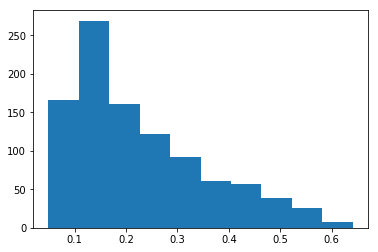

In [76]:
plt.hist(gains.mean(0))

(array([1446.,  219.,  155.,  128.,  101.,   75.,   72.,   54.,   51.,
          38.,   47.,   32.,   43.,   29.,   34.,   22.,   32.,   21.,
          23.,   22.,   23.,   28.,   24.,   27.,   15.,   12.,   17.,
          12.,   15.,   14.,    9.,   14.,   14.,   19.,   13.,    8.,
          15.,   24.,   11.,   17.,    7.,   11.,   13.,   11.,   19.,
           9.,   14.,    6.,   10.,   10.,   12.,   11.,   10.,   12.,
          11.,    9.,   19.,    6.,    8.,   16.,   11.,   11.,    9.,
          13.,    8.,   12.,   12.,   10.,   11.,    9.,   11.,   13.,
          12.,   13.,    9.,   15.,    8.,   11.,   11.,    8.,   20.,
          10.,   11.,   11.,    9.,   12.,    8.,   13.,   12.,   22.,
          12.,   15.,   15.,   12.,   22.,   18.,   21.,   30.,   30.,
          80.]),
 array([5.74621484e-09, 9.99996420e-03, 1.99999226e-02, 2.99998811e-02,
        3.99998395e-02, 4.99997980e-02, 5.99997564e-02, 6.99997149e-02,
        7.99996733e-02, 8.99996318e-02, 9.99995902e-02, 1.

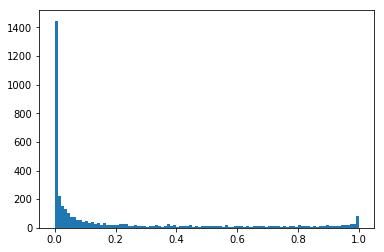

In [59]:
plt.hist(1 - np.tanh(sim.mons['rnn.x'][:,9])**2, bins=100)

In [78]:
m = np.hstack([m1.reshape(-1, 1), m2.reshape(-1, 1)])

x = sim.mons['rnn.x']
k = np.linalg.pinv(m).dot(x.T)

In [ ]:
U, S, VT = np.linalg.svd(x)
v1 = VT[0,:]
v2 = VT[1,:]
#x_perp = x - np.multiply.outer(x.dot(m1), m1) - np.multiply.outer(x.dot(m2), m2)
x_perp = x - np.multiply.outer(x.dot(v1), v1) - np.multiply.outer(x.dot(v2), v2)

In [ ]:
#cov = compute_empirical_covariance(x_perp)
#off_diags = cov[np.triu_indices(cov.shape[0], k = 1)]
#cov_mean = off_diags.mean()
#cov_std = off_diags.std()

In [ ]:
#eigs, vecs = np.linalg.eig(cov)

In [ ]:
#plt.plot(sorted(np.abs(eigs))[::-1], '.')

In [ ]:
#proj = np.linalg.qr(np.random.normal(0, 1, (N,N)))[0][:2,:]
#random_k = proj.dot(x.T)
#plt.plot(random_k[0], random_k[1], alpha=0.8)

In [ ]:
#fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#U, S, VT = np.linalg.svd(x)
#x_p_proj = VT[:2,:].dot(x.T)
#ax[0].plot(x_p_proj[0], x_p_proj[1], alpha=0.8)
#ax[0].set_xlim([-600, 600])
#ax[0].set_ylim([-600, 600])
#ax[0].set_title('x 2 PCs')
#U, S, VT = np.linalg.svd(x_perp)
#x_p_proj = VT[:2,:].dot(x_perp.T)
#ax[1].plot(x_p_proj[0], x_p_proj[1], alpha=0.8)
#ax[1].set_xlim([-600, 600])
#ax[1].set_ylim([-600, 600])
#ax[1].set_title('x perp 2 PCs')
#fig.savefig('figs/residual_oscillations_PC_subtract.pdf')

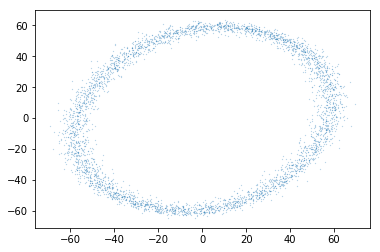

In [79]:
plt.plot(k[0], k[1], '.', alpha=0.8, markersize=0.3)
#plt.xlim([450, 550])
#plt.ylim([550, 650])

In [ ]:
#evals = np.array(sorted(np.abs(eigs))[::-1])
#processed_data = np.zeros(4000)
#processed_data[:len(evals)] = evals
processed_data = k
#processed_data = np.array([cov_mean, cov_std])

sim.runs_x = x[-int(100/ode_method.dt):,:10].copy()
sim.times = sim.mons['t'][-int(100/ode_method.dt):].copy()

dT_cov = 1
dT_cov_steps = int(dT_cov/(ode_method.dt*sim.T_monitor_interval))
PR_x = compute_approximate_participation_coefficient(x_perp[::dT_cov_steps], n_derangments=50)
sim.PR_x = PR_x

if not prototype:
    del sim.rnn.W
    del sim.mons['rnn.x']
    del sim.mons['t']

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [20]:
###Truncate file above
file_name = 'limit_cycles_proj'
job_name = 's_g_N_dim_subtract_big_data'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook limit_cycles_proj.ipynb to script
[NbConvertApp] Writing 17192 bytes to limit_cycles_proj.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b1dffe76dd8> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b1dffe76dd8> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [29]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=8)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
job_id_1 = submit_job(job_script_path, n_jobs)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/s_g_N_dim_subtract_big_data/result_*’: No such file or directory
sending incremental file list

sent 1,333 bytes  received 28 bytes  2,722.00 bytes/sec
total size is 196,088  speedup is 144.08


In [4]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1438588    lkumar  jupyter   om2382  R      10:43      1 ax16


In [11]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 's_g_N_dim_subtract_big_data'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [8]:
configs_array

{'s': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18],
 'g': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18],
 'N': [500, 1000, 2000],
 'i_seed': [0, 1, 2]}

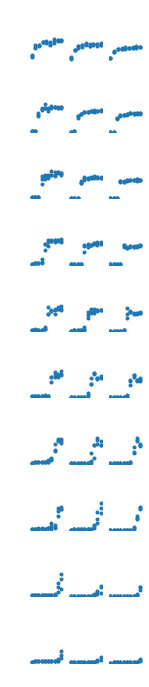

In [12]:
fig, ax = plt.subplots(10, 3, figsize=(2, 12))
for i_n in range(3):
    for i_s in range(10):
        for i_seed in range(3):
            PRs = []
            for i_g in range(10):
                PRs.append(sim_dict['{}_{}_{}_{}'.format(configs_array['s'][i_s],
                                                      configs_array['g'][i_g],
                                                      configs_array['N'][i_n],
                                                      i_seed)].PR_x)
            ax[i_s, i_n].plot(PRs, '.', color='C0')
            ax[i_s, i_n].set_ylim([0, 0.2])
        ax[i_s, i_n].axis('off')
#fig.savefig('figs/no_subtract_g_s_prs.pdf')

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(2, 12))
for i_s in range(10):
    for i_seed in range(5):
        PRs = []
        for i_g in range(10):
            PRs.append(sim_dict['{}_{}_{}'.format(configs_array['s'][i_s],
                                                  configs_array['g'][i_g],
                                                  i_seed)].PR_x)
        ax[i_s].plot(PRs, '.', color='C0')
        ax[i_s].set_ylim([0, 0.1])

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i,j].set_title('s = {}'.format(configs_array['s'][3*i + j]))
        for k in range(5):
            ax[i,j].plot(configs_array['N'],results_array[3*i + j,:,k,1], '.', color='C0')

for j in range(3):
    ax[-1,j].set_xlabel('N')
ax[0,0].set_ylabel('Std. Dev. of cov off-diagonals')

In [ ]:
PRs = np.square(results_array[:,:,:,:].sum(-1)) / np.square(results_array[:,:,:,:]).sum(-1)
PR_trunk = np.square(results_array[:,:,:,2:].sum(-1)) / np.square(results_array[:,:,:,2:]).sum(-1)
all_PRs = np.concatenate([PRs, PR_trunk], axis=1)

In [ ]:
fig, ax = plt.subplots(20, 6, figsize=(6, 20))
for i in range(20):
    for j in range(6):
        ax[i,j].plot(all_PRs[i,j,:]/(configs_array['N'][j % 3] - 2*(j>2)), '.')
        ax[i,j].axis('off')
        ax[i,j].axhline(y=0, color='k')
        ax[i,j].set_ylim([0,0.2])
#fig.suptitle('g = 17')
fig.savefig('figs/PR_truncate_comp.pdf')

In [ ]:
fig, ax = plt.subplots(20, 3, figsize=(3, 20))
for i in range(20):
    for j in range(3):
        ax[i,j].plot(results_array[i,j,0,0,:], results_array[i,j,0,1,:], '.', alpha=0.8, markersize=0.3)
        ax[i,j].axis('off')
        ax[i,j].axis('equal')
        #ax[i,j].axhline(y=0, color='k')
        #ax[i,j].set_ylim([0,0.2])
#fig.suptitle('g = 17')
fig.savefig('figs/PR_truncate_traj.pdf')

In [ ]:
fig, ax = plt.subplots(20, 3, figsize=(3, 10))
for i in range(20):
    for j in range(3):
        ax[i,j].plot(results_array[i,j,0,:configs_array['N'][j]], '.', markersize=0.8)
        ax[i,j].set_ylim([0, 1.2 * np.amax(results_array)])
        ax[i,j].axis('off')
fig.savefig('figs/cov_evals.png', format='png')

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(4, 12))
for i in range(3):
    #ax[i,0].set_ylabel('g = {:2f}'.format(configs_array['g'][i]))
    for j in range(4):
        #ax[i,j].plot(results_array[i,j,0,::10], results_array[i,j,1,::10], markersize=0.3,alpha=0.8, linewidth=0.3)
        ax[i,j].plot(results_array[i,j,0,::10], results_array[i,j,1,::10], '.', markersize=0.3,alpha=0.8)
        ax[i,j].axis('equal')
        ax[i,j].axis('off')
        pr = sim_dict['{}_{}'.format(configs_array['N'][i], j)].PR_x
        ax[i,j].set_title('%.4f'%pr)
        #ax[i,j].set_title('{}_{}'.format(configs_array['N'][i], j))
#fig.suptitle('s = {}'.format(configs_array['g'][k]))

In [ ]:
for k in range(5):
    fig, ax = plt.subplots(5, 4, figsize=(4, 15))
    for i in range(5):
        ax[i,0].set_ylabel('g = {:2f}'.format(configs_array['g'][i]))
        for j in range(4):
            #ax[i,j].plot(results_array[i,j,0,::10], results_array[i,j,1,::10], markersize=0.3,alpha=0.8, linewidth=0.3)
            ax[i,j].plot(results_array[i,k,j,0,::10], results_array[i,k,j,1,::10], '.', markersize=0.3,alpha=0.8)
            ax[i,j].axis('equal')
            ax[i,j].axis('off')
            #pr = sim_dict['{}_{}_{}'.format(configs_array['g'][i], configs_array['s'][k], j)].PR_x
            #ax[i,j].set_title('%.4f'%pr)
            ax[i,j].set_title('{}_{}'.format(configs_array['g'][i], configs_array['s'][k]))
#fig.suptitle('s = {}'.format(configs_array['g'][k]))

In [ ]:
for i_key, key in enumerate(sim_dict.keys()):
    plt.figure()
    plt.plot(results_array[i_key,0,::1], results_array[i_key,1,::1], '.', markersize=0.3,alpha=0.8)
    plt.axis('equal')
    plt.title('pr = {}.'.format(sim_dict[key].PR_x))

In [ ]:
for k in range(4):
    fig, ax = plt.subplots(5, 4, figsize=(4, 15))
    for i in range(5):
        ax[i,0].set_ylabel('g = {:2f}'.format(configs_array['g'][i]))
        for j in range(4):
            ax[i,j].plot(results_array[i,k,j,0,::10], results_array[i,k,j,1,::10], '.', markersize=0.2,alpha=0.2)
            ax[i,j].axis('equal')
            ax[i,j].axis('off')
    fig.suptitle('s = {}'.format(configs_array['s'][k]))
    #fig.savefig('figs/cycle_g_n={}'.format(configs_array['n'][k]))

In [ ]:
for k in range(3):
    fig, ax = plt.subplots(20, 4, figsize=(4, 15))
    for i in range(20):
        ax[i,0].set_ylabel('g = {:2f}'.format(configs_array['g'][i]))
        for j in range(4):
            ax[i,j].plot(results_array[i,k,j,0,::10], results_array[i,k,j,1,::10], '.', markersize=0.2,alpha=0.2)
            ax[i,j].axis('equal')
            ax[i,j].axis('off')
    fig.suptitle('N = {}'.format(configs_array['n'][k]))
    fig.savefig('figs/cycle_g_n={}'.format(configs_array['n'][k]))
    

In [ ]:
!ls figs/

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i_ax in range(6):
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed,0], '.', color='k')
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed,1], '.', color='C3')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i_ax in range(2):
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['g'], results_array[i_ax,:,i_seed,0], '.', color='k')
        ax[i_ax].plot(configs_array['g'], results_array[i_ax,:,i_seed,1], '.', color='C3')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i_ax in range(3):
    ax[i_ax].set_title('N = {}'.format(configs_array['N'][i_ax]))
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed], '.', color='k')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
for i_ax in range(2):
    ax[i_ax].set_title('N = {}'.format(configs_array['N'][i_ax]))
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed], '.', color='k')

In [ ]:
plt.plot(configs_array['structure'], results_array[:,:,0].mean(1), '.', color='k')
plt.plot(configs_array['structure'], results_array[:,:,1].mean(1), '.', color='r')
plt.xlabel(key_order[0])

In [ ]:
for i in range(10):
    plt.plot(configs_array['structure'], results_array[:,i,0], '.', color='k')
    #plt.plot(configs_array['structure'], results_array[:,i,1], '.', color='r')
plt.xlabel(key_order[0])
plt.ylabel('$PR_x$')
plt.title('N = 1000, g = 2.25')

In [ ]:
theory = []
for g in configs_array['g']:
    theory.append(solve_for_Delta_0(g))
#plt.plot(configs_array['g'], theory, color='k')
for i in range(len(configs_array['n'])):
    fig = plt.figure()
    plt.plot(configs_array['g'], theory, color='k')
    for j in range(len(configs_array['i_seed'])):
        plt.plot(configs_array['g'], results_array[i, :, j], '.', color='C{}'.format(i))
    plt.xlabel('g')
    plt.ylabel('$\Delta_0$')
    plt.title('n = {}'.format(configs_array['n'][i]))
    plt.xticks(configs_array['g'])
    plt.ylim([-0.05, 3.5])
    fig.savefig('figs/delta0_n={}.pdf'.format(configs_array['n'][i]), format='pdf')

In [ ]:
def plot_2d_array_of_time_series(configs_array, results_array, common_ylim=None):
    
    n_x, n_y, n_seeds, n_t = results_array.shape[:]
    keys = [key for key in configs_array.keys()]
    fig, ax = plt.subplots(n_x, n_y, figsize=(10,10))
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_seeds):
                ax[i, j].plot(results_array[i,j,k,:], color='C0')
            if common_ylim is not None:
                ax[i, j].set_ylim(common_ylim)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[0, j].set_title('{} = {}'.format(keys[1], configs_array[keys[1]][j]))
            ax[i, 0].set_ylabel('{} = {}'.format(keys[0], configs_array[keys[0]][i]))

In [ ]:
plot_2d_array_of_time_series(configs_array, results_array)

In [ ]:
results_array.shape
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(4):
    for j in range(3):
        for k in range(5):
            ax[i,j].plot(results_array[i,j,k,::100], color='C0')
            #ax[i,j].set_ylim([-0.01, 0.01])

#fig.savefig('figs/n_ginit.pdf', format='pdf')

In [ ]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order,
                                            tick_rounding=5, vmin=0, vmax=0.02, cmap='Blues')
#fig.savefig('figs/T_n_dt_pr.pdf')

In [ ]:
results_array.shape

In [ ]:
fig = plt.figure()
colors = ['k', 'C3']
#colors = ['g', 'y']
for i_pr, pr in enumerate(['Demeaned X', 'X', 'Demeaned Phi', 'Phi']):
    for i_seed, seed in enumerate(configs_array['i_seed']):
        plt.plot(configs_array['structure'], results_array[:, 9, i_seed, i_pr], '.', color=colors[i_pr//2])
plt.xticks(configs_array['structure'])
plt.ylim([0, 0.03])
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('mn/N')
plt.ylabel('$PR$')
#plt.axhline(y=0.0602, color='k', linestyle='--')
#plt.axhline(y=0.126, color='k', linestyle='--')
#fig.savefig('figs/mean_demeaned_structure_pr.pdf')

In [ ]:
fig, ax = plt.subplots(16, 16, figsize=(30, 30))
for i in range(10):
    for i_s, s in enumerate(configs_array['structure']):
        for i_g, g in enumerate(configs_array['g']):
            ax[15 - i_s, i_g].plot(sim_dict['{}_{}_0'.format(s, g)].runs_x[:,i], color='C{}'.format(i))
            ax[i_s, i_g].axis('off')
            #ax[i_s].axhline(y=sim_dict['{}_0'.format(s)].runs_x[:,i].mean(), color='C{}'.format(i))
            #ax[i_s].set_ylim([-3, 3])

In [ ]:
#fig.savefig('figs/dim_bifurcations.pdf')

In [ ]:
!ls figs

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
colors = ['k', 'C3']
for i_ax, g in enumerate(configs_array['g']):
    i_x = i_ax // 4
    i_y = i_ax % 4
    for i_pr, pr in enumerate(['Demeaned X', 'X', 'Demeaned Phi', 'Phi']):
        for i_seed, seed in enumerate(configs_array['i_seed']):
            ax[i_x, i_y].plot(configs_array['structure'], results_array[:, i_ax, i_seed, i_pr], '.', color=colors[i_pr//2])
    ax[i_x, i_y].set_xticks(configs_array['structure'])
    ax[i_x, i_y].set_ylim([-0.01, 0.08])
    ax[i_x, i_y].set_xticks([0, 1, 2, 3, 4])
    #ax[i_x, i_y].axis('off')
    ax[i_x, i_y].set_title('g = {}'.format(g))
    ax[i_x, i_y].set_xlabel('mn/N')
    plt.tight_layout()